In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

In [3]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages:Annotated[list,add_messages]
graph_builder = StateGraph(State)

In [4]:
graph_builder

In [5]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [6]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm=ChatGroq(model="llama-3.3-70b-versatile")

In [7]:
llm

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 32768, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x00000247940F7DA0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002479428C560>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [18]:
llm=init_chat_model("groq:llama-3.3-70b-versatile")
llm

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 32768, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x0000025F72308CE0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000025F73F4F9E0>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [8]:
## Node Functionality
def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

In [9]:
graph_builder=StateGraph(State)

## Adding node
graph_builder.add_node("llmchatbot",chatbot)
## Adding Edges
graph_builder.add_edge(START,"llmchatbot")
graph_builder.add_edge("llmchatbot",END)

## compile the graph
graph=graph_builder.compile()

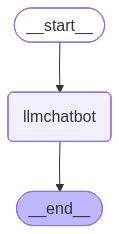

In [10]:
## Visualize the graph
from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [11]:
response=graph.invoke({"messages":"Hi"})

In [12]:
print(response["messages"][-1].content)

It's nice to meet you. Is there something I can help you with or would you like to chat?


In [13]:
for event in graph.stream({"messages":"Hi How are you?"}):
    for value in event.values():
        print(value["messages"][-1].content)

Hello. I'm just a language model, so I don't have feelings or emotions like humans do, but I'm functioning properly and ready to assist you with any questions or topics you'd like to discuss. How about you? How's your day going?


### Chatbot With Tool

In [14]:
from langchain_tavily import TavilySearch

tool=TavilySearch(max_results=2)
tool.invoke("What is langgraph")

{'query': 'What is langgraph',
 'response_time': 0.61,
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.geeksforgeeks.org/machine-learning/what-is-langgraph/',
   'title': 'What is LangGraph? - GeeksforGeeks',
   'content': 'LangGraph is an open-source framework built by LangChain that streamlines the creation and management of AI agent workflows.',
   'score': 0.999984,
   'raw_content': None},
  {'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
   'title': 'LangGraph Tutorial: What Is LangGraph and How to Use It?',
   'content': 'LangGraph is a library within the LangChain ecosystem that provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured and efficient manner. By managing the flow of data and the sequence of operations, LangGraph allows developers to focus on the high-level logic of their applications rather than the intricacies of agent coordination. Whether you ne

In [15]:
## Custom function
def multiply(a:int,b:int)->int:
    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    return a*b

In [16]:
tools=[tool,multiply]

In [17]:
llm_with_tool=llm.bind_tools(tools)

In [18]:
llm_with_tool

RunnableBinding(bound=ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 32768, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x00000247940F7DA0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002479428C560>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input

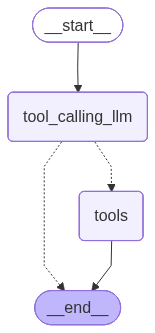

In [19]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
response=graph.invoke({"messages":"What is the recent ai news"})

In [23]:
graph.invoke({"messages":"What is the recent ai news"})

{'messages': [HumanMessage(content='What is the recent ai news', additional_kwargs={}, response_metadata={}, id='db1e8add-3314-465b-90cc-ad8f9b58d0b3'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'eqznx5sx6', 'function': {'arguments': '{"query":"recent AI news","time_range":"day","topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 1751, 'total_tokens': 1782, 'completion_time': 0.091098461, 'completion_tokens_details': None, 'prompt_time': 0.085989231, 'prompt_tokens_details': None, 'queue_time': 0.052984498, 'total_time': 0.177087692}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_c06d5113ec', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019bf820-402c-7162-99cf-f2f89f39dbae-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'recent AI news', 'time_range': 'day', 'topic': 'n

In [21]:
print(response['messages'][-1].content)

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://techcrunch.com/2026/01/25/apple-will-reportedly-unveil-its-gemini-powered-siri-assistant-in-february/", "title": "Apple will reportedly unveil its Gemini-powered Siri assistant in February - TechCrunch", "score": 0.9635062, "published_date": "Sun, 25 Jan 2026 16:56:31 GMT", "content": "# Apple will reportedly unveil its Gemini-powered Siri assistant in February. We’re about to get our first real look at the results of the recently announced AI partnership between Apple and Google, according to Bloomberg’s Mark Gurman. Gurman reports that Apple is planning to announce a new version of Siri in the second half of February. Using Google’s Gemini AI models, this Siri update will reportedly be the first to live up to the promises Apple made in June 2024, with the ability to complete tasks by accessing user’s personal data and on-screen content. Earlier reports suggested that Ap

In [22]:
response['messages'][-1].content

'{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://techcrunch.com/2026/01/25/apple-will-reportedly-unveil-its-gemini-powered-siri-assistant-in-february/", "title": "Apple will reportedly unveil its Gemini-powered Siri assistant in February - TechCrunch", "score": 0.9635062, "published_date": "Sun, 25 Jan 2026 16:56:31 GMT", "content": "# Apple will reportedly unveil its Gemini-powered Siri assistant in February. We’re about to get our first real look at the results of the recently announced AI partnership between Apple and Google, according to Bloomberg’s Mark Gurman. Gurman reports that Apple is planning to announce a new version of Siri in the second half of February. Using Google’s Gemini AI models, this Siri update will reportedly be the first to live up to the promises Apple made in June 2024, with the ability to complete tasks by accessing user’s personal data and on-screen content. Earlier reports suggested that A

In [24]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recent ai news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (psf418b5y)
 Call ID: psf418b5y
  Args:
    query: recent AI news
    time_range: day
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://techcrunch.com/2026/01/25/apple-will-reportedly-unveil-its-gemini-powered-siri-assistant-in-february/", "title": "Apple will reportedly unveil its Gemini-powered Siri assistant in February - TechCrunch", "score": 0.9635062, "published_date": "Sun, 25 Jan 2026 16:56:31 GMT", "content": "# Apple will reportedly unveil its Gemini-powered Siri assistant in February. We’re about to get our first real look at the results of the recently announced AI partnership be

In [25]:
response=graph.invoke({"messages":"What is 5 multiplied by 2"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 5 multiplied by 2
================================== Ai Message ==================================
Tool Calls:
  multiply (1h4nyrfn7)
 Call ID: 1h4nyrfn7
  Args:
    a: 5
    b: 2
================================= Tool Message =================================
Name: multiply

10


In [26]:
response=graph.invoke({"messages":"Give me the recent ai news and then multiply 5 by 10"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (0b3hz3hjx)
 Call ID: 0b3hz3hjx
  Args:
    query: recent ai news
    search_depth: basic
    time_range: day
    topic: news
  multiply (y3ym0355g)
 Call ID: y3ym0355g
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://techcrunch.com/2026/01/25/apple-will-reportedly-unveil-its-gemini-powered-siri-assistant-in-february/", "title": "Apple will reportedly unveil its Gemini-powered Siri assistant in February - TechCrunch", "score": 0.94458723, "published_date": "Sun, 25 Jan 2026 16:56:31 GMT", "content": "# Apple will reportedly unveil its Gemini-powered Siri

#### ReAct Agent Architecture

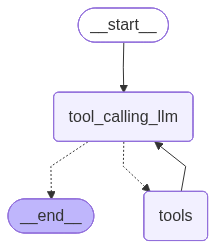

In [27]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [28]:
response=graph.invoke({"messages":"Give me the recent ai news and then multiply 5 by 10"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (1azb4x2ta)
 Call ID: 1azb4x2ta
  Args:
    query: recent ai news
    search_depth: basic
    time_range: day
    topic: news
  multiply (bjkg8xzhb)
 Call ID: bjkg8xzhb
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://techcrunch.com/2026/01/25/apple-will-reportedly-unveil-its-gemini-powered-siri-assistant-in-february/", "title": "Apple will reportedly unveil its Gemini-powered Siri assistant in February - TechCrunch", "score": 0.94458723, "published_date": "Sun, 25 Jan 2026 16:56:31 GMT", "content": "# Apple will reportedly unveil its Gemini-powered Siri

#### Adding Memory In Agentic Graph

In [29]:
response=graph.invoke({"messages":"Hello my name is KRish"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello my name is KRish
================================== Ai Message ==================================

Hello KRish, it's nice to meet you. Is there something I can help you with or would you like to chat?


In [30]:
response=graph.invoke({"messages":"What is my name"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is my name
================================== Ai Message ==================================

I don't have any information about your name. This conversation just started, and we haven't discussed any personal details yet. If you'd like to share your name, I'd be happy to get to know you better!


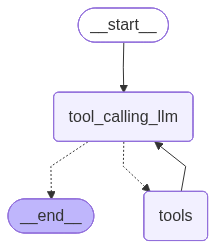

In [38]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile(checkpointer=memory)

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [39]:
config={"configurable":{"thread_id":"1"}}

response=graph.invoke({"messages":"Hi my name is Krish"},config=config)

for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi my name is Krish
================================== Ai Message ==================================

Hello Krish, it's nice to meet you. Is there something I can help you with or would you like to chat?


In [40]:
response=graph.invoke({"messages":"Hey what is my name"},config=config)

print(response['messages'][-1].content)

Your name is Krish.


#### Streaming 

In [41]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()

In [42]:
def superbot(state:State):
    return {"messages":[llm.invoke(state['messages'])]}

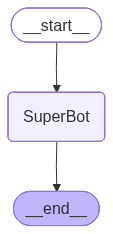

In [43]:
graph=StateGraph(State)

## node
graph.add_node("SuperBot",superbot)
## Edges

graph.add_edge(START,"SuperBot")
graph.add_edge("SuperBot",END)


graph_builder=graph.compile(checkpointer=memory)


## Display
from IPython.display import Image, display
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [44]:
## Invocation

config = {"configurable": {"thread_id": "1"}}

graph_builder.invoke({'messages':"Hi,My name is Krish And I like cricket"},config)

{'messages': [HumanMessage(content='Hi,My name is Krish And I like cricket', additional_kwargs={}, response_metadata={}, id='e8b6d3fd-423c-4eb3-bf87-73bcb556886e'),
  AIMessage(content="Nice to meet you, Krish! Cricket is an amazing sport, isn't it? What do you like most about cricket? Are you a fan of a particular team or player? Do you play cricket yourself or enjoy watching it? Let's chat about cricket!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 53, 'prompt_tokens': 45, 'total_tokens': 98, 'completion_time': 0.155126596, 'completion_tokens_details': None, 'prompt_time': 0.00114894, 'prompt_tokens_details': None, 'queue_time': 0.05847943, 'total_time': 0.156275536}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_68f543a7cc', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019bf83e-1271-7643-a78a-ac621284626d-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={

#### Streaming
Methods: .stream() and astream()

- These methods are sync and async methods for streaming back results.
Additional parameters in streaming modes for graph state

- **values** : This streams the full state of the graph after each node is called.
- **updates** : This streams updates to the state of the graph after each node is called.

In [45]:
# Create a thread
config = {"configurable": {"thread_id": "3"}}

for chunk in graph_builder.stream({'messages':"Hi,My name is Krish And I like cricket"},config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content="Nice to meet you, Krish! Cricket is an exciting sport, isn't it? Which team or player is your favorite? Are you a fan of international cricket, IPL, or do you enjoy playing the game yourself?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 45, 'total_tokens': 90, 'completion_time': 0.150818809, 'completion_tokens_details': None, 'prompt_time': 0.001198292, 'prompt_tokens_details': None, 'queue_time': 0.054600798, 'total_time': 0.152017101}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_c06d5113ec', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019bf844-c67d-7c73-8ccf-dc1533b776d3-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 45, 'output_tokens': 45, 'total_tokens': 90})]}}


In [46]:
for chunk in graph_builder.stream({'messages':"Hi,My name is Krish And I like cricket"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is Krish And I like cricket', additional_kwargs={}, response_metadata={}, id='614cec29-b196-40f5-8723-0a23ffad1d11'), AIMessage(content="Nice to meet you, Krish! Cricket is an exciting sport, isn't it? Which team or player is your favorite? Are you a fan of international cricket, IPL, or do you enjoy playing the game yourself?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 45, 'total_tokens': 90, 'completion_time': 0.150818809, 'completion_tokens_details': None, 'prompt_time': 0.001198292, 'prompt_tokens_details': None, 'queue_time': 0.054600798, 'total_time': 0.152017101}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_c06d5113ec', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019bf844-c67d-7c73-8ccf-dc1533b776d3-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 45, 'output_toke

In [47]:
# Create a thread
config = {"configurable": {"thread_id": "4"}}

for chunk in graph_builder.stream({'messages':"Hi,My name is Krish And I like cricket"},config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content='Nice to meet you, Krish! Cricket is an exciting sport, and there are so many talented players and teams to follow. Are you a fan of a particular team or player? Do you play cricket yourself, or do you just enjoy watching it?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 45, 'total_tokens': 96, 'completion_time': 0.172328999, 'completion_tokens_details': None, 'prompt_time': 0.003689679, 'prompt_tokens_details': None, 'queue_time': 0.056934191, 'total_time': 0.176018678}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_68f543a7cc', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019bf845-7991-76d0-921d-dcb3d708ccde-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 45, 'output_tokens': 51, 'total_tokens': 96})]}}


In [48]:
for chunk in graph_builder.stream({'messages':"I also like football"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is Krish And I like cricket', additional_kwargs={}, response_metadata={}, id='de0de0d0-63ea-4a31-bd2c-3924cb676380'), AIMessage(content='Nice to meet you, Krish! Cricket is an exciting sport, and there are so many talented players and teams to follow. Are you a fan of a particular team or player? Do you play cricket yourself, or do you just enjoy watching it?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 45, 'total_tokens': 96, 'completion_time': 0.172328999, 'completion_tokens_details': None, 'prompt_time': 0.003689679, 'prompt_tokens_details': None, 'queue_time': 0.056934191, 'total_time': 0.176018678}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_68f543a7cc', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019bf845-7991-76d0-921d-dcb3d708ccde-0', tool_calls=[], invalid_tool_calls=[], usage_metadata=

In [49]:
config = {"configurable": {"thread_id": "5"}}

async for event in graph_builder.astream_events({"messages":["Hi My name is Krish and I like to play cricket"]},config,version="v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi My name is Krish and I like to play cricket']}}, 'name': 'LangGraph', 'tags': [], 'run_id': '019bf846-495d-7ff0-9d17-b284de03b1f3', 'metadata': {'thread_id': '5'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi My name is Krish and I like to play cricket', additional_kwargs={}, response_metadata={}, id='b223b78c-8024-48bd-b05b-8edf6b1ff678')]}}, 'name': 'SuperBot', 'tags': ['graph:step:1'], 'run_id': '019bf846-4960-7800-8b71-0aa145a70f1b', 'metadata': {'thread_id': '5', 'langgraph_step': 1, 'langgraph_node': 'SuperBot', 'langgraph_triggers': ('branch:to:SuperBot',), 'langgraph_path': ('__pregel_pull', 'SuperBot'), 'langgraph_checkpoint_ns': 'SuperBot:7e814c14-17ee-d9e7-1cc4-05a7e0bea7e5'}, 'parent_ids': ['019bf846-495d-7ff0-9d17-b284de03b1f3']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='Hi My name is Krish and I like to pla